In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
plt.rcParams["font.family"] = "Times New Roman"
#matplotlib.rcParams['text.usetex'] = True
import os
import pandas as pd

In [2]:
def K(t, d):
    alpha = 1
    return pow(t, 2*alpha/(3*alpha+d)) * np.log10(t)

def xyz_to_eqr(x,y,z):
    if x == 0:
        if y >= 0:
            theta = np.pi/2
        else:
            theta = -np.pi/2
    else:
        theta = np.arctan(y/x)
        if x < 0:
            if theta >= 0:
                theta -= np.pi
            else:
                theta += np.pi
    if pow(x,2)+pow(y,2) == 0:
        if z > 0:
            phi = np.pi/2
        else:
            phi = -np.pi/2
    else:
        phi = np.arctan(z/np.sqrt(pow(x,2)+pow(y,2)))

    #_x = int(np.floor((theta + np.pi) / (2*np.pi) * N_x))
    #_y = int(np.floor((phi + np.pi/2) / (np.pi) * N_y))
    return theta, phi

def eqr_to_xyz(theta, phi):
    return np.cos(phi)*np.cos(theta), np.cos(phi)*np.sin(theta), np.sin(phi)

def tile_to_xyz(i, j, N_x, N_y):
    eqr = tile_to_eqr(i, j, N_x, N_y)
    
    x = np.cos(eqr[0]) * np.cos(eqr[1])
    y = np.sin(eqr[0]) * np.cos(eqr[1])
    z = np.sin(eqr[1])
    
    return x,y,z

def tile_to_eqr(i, j, N_x, N_y):
    theta = (-1 + (2*i + 1) / N_x) * np.pi
    phi = (-1 + (2*j + 1) / N_y) * np.pi / 2
    
    return (theta, phi)

def eqr_to_tile(x, y, N_x, N_y):
    x += np.pi
    y += np.pi/2
    
    i = int(np.floor(x / np.pi / 2 * N_x)) % N_x
    j = int(np.floor(y / np.pi * N_y)) % N_y
    
    return (i,j)

def fov_edge_degree(pitch, theta):
    x, y = fov_edge(pitch, theta)
    return x * 180 / np.pi, y * 180 / np.pi

def fov_edge(pitch, theta):
    theta = theta / 180 * np.pi
    pitch = pitch / 180 * np.pi
    rotate = np.array([[np.cos(pitch), 0, np.sin(pitch)], \
                      [0, 1, 0], \
                      [-np.sin(pitch), 0, np.cos(pitch)]])
    ref = np.array([np.cos(theta), np.sin(theta), 0])
    corner = np.matmul(rotate, np.transpose(ref))

    lon = np.arccos(corner[0] / np.linalg.norm(corner[:2]))
    if theta != 0:
        lon *= np.abs(theta) / theta
    lat = np.arccos(corner[0] * np.cos(lon) + corner[1] * np.sin(lon))
    if pitch != 0:
        lat *= np.abs(pitch) / pitch

    #return lon / np.pi * 180, lat / np.pi * 180
    return lon, lat

def collect_viewport(offset_x, offset_y, width, height, N_x, N_y):
    _x = offset_x
    offset_x = int(offset_x / np.pi * 180)
    offset_y = int(offset_y / np.pi * 180)
    width = int(width / np.pi * 180)
    height = int(height / np.pi * 180)
    
    collect_tile = set()
    
    for _ in range(2):
        for p in range(-height + offset_y, height + 1 + offset_y, 2):
            tmp = fov_edge(p, width)
            collect_tile.add(eqr_to_tile(tmp[0] + _x, tmp[1], N_x, N_y))
        for p in range(width, -width-1, -2):
            tmp = fov_edge(height + offset_y, p)
            collect_tile.add(eqr_to_tile(tmp[0] + _x, tmp[1], N_x, N_y))
        for p in range(height + offset_y, -height-1 + offset_y, -2):
            tmp = fov_edge(p, -width)
            collect_tile.add(eqr_to_tile(tmp[0] + _x, tmp[1], N_x, N_y))
        for p in range(-width, width+1, 2):
            tmp = fov_edge(-height + offset_y, p)
            collect_tile.add(eqr_to_tile(tmp[0] + _x, tmp[1], N_x, N_y))
        
        width //= 2
        height //= 2
    
    return collect_tile

def distance(x, y, x_t, y_t):
    return np.arccos(np.cos(x-x_t)*np.cos(y)*np.cos(y_t) + np.sin(y)*np.sin(y_t))

def distortion(y_t):
    return np.cos(y_t)

def compute_QoE(x, y, x_t, y_t):
    return distortion(y_t) / (distance(x,y,x_t,y_t)+1)

def compute_all_QoE(x, y, N_x, N_y, width, height):
    V = collect_viewport(x, y, width, height, N_x, N_y)
    for (i,j) in V:
        eqr = tile_to_eqr(i, j, N_x, N_y)
        compute_QoE(x, y, eqr[0], eqr[1])

def zeta(s, e):
    tmp = e / pow(1.1, 3) / (s+1)
    return 2 / (1 + np.exp(-2 * tmp)) - 1

def value_function(x, tau, s, t, tau_mtp, ground_beta, estimate_beta, W, lamb, policy, value):
    #print(f"State: ({x}, {tau}, {s}, {t})")
    if x == 1:
        if t + tau <= tau_mtp:
            return ground_beta
            #return 0.2
        else:
            if t+tau-1 < W:
                return estimate_beta[t+tau-1]
            else:
                return estimate_beta[-1]
            #return 0.15
    else:
        if tau == 0:
            return 0
        
        if t == W:
            return estimate_beta[-1]
            #return 0.15
        
        tmp1 = 0
        tmp2 = 0
        
        for _s in range(len(P)):
            tmp1 += P[s][_s] * value[(1, tau-1, _s, t+1)]
            tmp2 += P[s][_s] * value[(0, tau-1, _s, t+1)]
        
        def value_with_e(e):
            #print(f"e = {e}")
            #print(f"lamb[tau-1] = {lamb[tau-1]}")
            #print(f"zeta(s, e) = {zeta(s, e)}")
            #print(f"tmp1 = {tmp1}")
            #print(f"tmp2 = {tmp2}")
            return -(-lamb[w+1-tau] * e + zeta(s, e) * tmp1 + (1 - zeta(s, e)) * tmp2)
        #if (x, tau, s, t) == (0, 1, 3, 1):
        #print(f"lamb[{w+1-tau}] = {lamb[w+1-tau]}")
        #print(f"tmp1 = {tmp1}")
        #print(f"tmp2 = {tmp2}")
        #for e in range(0, 30, 5):
        #    print(e, -value_with_e(e))
        sol = minimize_scalar(value_with_e, bounds=(0, 5), method='bounded')
        
        #if (x, tau, s, t) == (0, 1, 3, 1):
        #    print(f"tmp1 = {tmp1}")
        #    print(f"tmp2 = {tmp2}")
        #    print(f"e* = {sol.x}")
        #    print(f"value = {sol.fun}")
        
        #print(f"e_star = {e_star}")
        #if lamb[t]>100:
        #    print(f"state = {x}, {tau}, {s}, {t}, lamb[tau-1] = {lamb[tau-1]}")
        #    print(tmp1)
        #    print(tmp2)
        #    print(e_star)
        #    print()
        policy[(x, tau, s, t)] = sol.x
        
        if -sol.fun > 100:
            print(f"value = {-sol.fun}")
            print(f"policy = {sol.x}")
            print(f"tmp1 = {tmp1}")
            print(f"tmp2 = {tmp2}")
        
        return -sol.fun

In [3]:
def actual_Q1_Q2(rates, grounds, weights):
    # Q1
    theta = 2000000.
    Q1 = []
    waste_ratio = np.zeros(len(rates))
    miss_ratio = np.zeros(len(rates))
    lon_step = 20
    lat_step = 10
    
    for ind, t in enumerate(rates.keys()):
        N_x = rates[t].shape[0]
        N_y = rates[t].shape[1]
        tile_width = np.pi * 2 / N_x
        tile_height = np.pi / N_y
        weighted = []
        sample = []
        waste = []
        miss = 0
        for l2 in np.arange(-np.pi/2, np.pi/2, np.pi/lat_step):
            for l1 in np.arange(-np.pi, np.pi, 2*np.pi/(lon_step*np.cos(l2))):
                i, j = eqr_to_tile(l1, l2, N_x, N_y)
                x, y, z = eqr_to_xyz(l1, l2)
                
                #print(i, j)
                #print(x, y, z)
                #print(grounds[t])
                
                dot = (grounds[t][0] * x + grounds[t][1] * y + grounds[t][2] * z) / \
                np.sqrt(x ** 2 + y ** 2 + z ** 2) * np.sqrt(grounds[t][0] ** 2 + grounds[t][1] ** 2 + grounds[t][2] ** 2)
                
                if dot > 0.5:
                    sample.append(rates[t][i][j])
                    weighted.append(rates[t][i][j])
                    if rates[t][i][j] == 0:
                        miss += 1
                    #if dot > np.sqrt(3) / 2:
                    #    weighted.append(rates[t][i][j])
                else:
                    waste.append(rates[t][i][j])
        
        #tmp = xyz_to_eqr(grounds[t][0], grounds[t][1], grounds[t][2])
        #_i, _j = eqr_to_tile(tmp[0], tmp[1], N_x, N_y)
        #print("center tile: ", _i, _j)
        w = np.sum(waste)
        s = np.sum(sample)
        waste_ratio[ind] = w / (w+s)
        
        miss_ratio[ind] = miss / np.sum(weights[t][weights[t] > 0])
        #print("ground: ", grounds[t])
        #print("pred: ", predictions[t][0])
        #print(rates[t])
        #print(waste, w)
        #print(sample, s)
        #print(N_x, N_y, waste_ratio[ind])
        
        #MSE = []
        #for s in weighted:
        #    tmp = 0.76 * np.exp((np.log(theta) - np.log(s * (N_x * N_y) ** 1)) / 1.195) + 0.68
        #    if np.isfinite(tmp) and tmp > 0:
        #        MSE.append(tmp)
        #Q1[ind] = 10 * np.log10(255**2 / np.average(MSE))
        #if np.average(weighted) == 0:
        #    Q1[ind] = 0
        #    print(rates[t], grounds[t])
        #else:
        if np.average(weighted) != 0:
            MSE = 0.76 * np.exp((np.log(theta) - np.log(np.average(weighted) * (N_x * N_y) ** 0.9)) / 1.195) + 0.68
            Q1.append(10 * np.log10(255**2 / MSE))
    
    Q2 = 0.
    last = -1
    for i in range(len(Q1)-1):
        Q2 += abs(Q1[i+1] - Q1[i])
    Q2 /= len(Q1)-1
    
    
    return np.average(Q1), Q2, np.average(waste_ratio), np.average(miss_ratio)

In [4]:
scheme = ['sweet', 'sweet_tbra', 'sweet_6x3']
#scheme = ['sweet', 'sweet_tbra', 'sweet_6x3', 'sweet_7x7', 'sweet_10x10']

user_video_pair = {}
all_pair = set()
record = {}

In [5]:
for sche in scheme:
    for _ in range(1):
        path  = f"../{sche}/"

        file_list = []
        for (dirpath, dirnames, filenames) in os.walk(path):
            file_list.extend(filenames)
            break

        user_video_pair[sche] = set()
        var_book = {'bandwidth_trace', 'bandwidth_pred', 'buffer', 'weights', \
                    'received_rate', 'received_qoe', 'ground', 'prediction'}
        check_var_set = {}

        for f in file_list:
            v, v1, v2, u = f.split('.')[0].rsplit('_', 3)
            if (sche, u, v1+'_'+v2) in check_var_set:
                check_var_set[(sche, u, v1+'_'+v2)].add(v)
            else:
                check_var_set[(sche, u, v1+'_'+v2)] = {v}

        for index in check_var_set.keys():
            #print(index)
            #print(len(check_var_set[index]))
            #print(len(var_book))
            #if len(check_var_set[index]) == len(var_book):
            user_video_pair[sche].add(index)
            all_pair.add(index)
        

index_name = pd.MultiIndex.from_tuples(all_pair, names=["scheme", "user", "video"])
df = pd.DataFrame([[[] for _ in range(len(var_book))] for _ in range(len(index_name))], \
                    index=index_name, columns=var_book, dtype='object')

for sche in scheme:
    for _ in range(1):
        path  = f"../{sche}/"
        for index in user_video_pair[sche]:
            for var in var_book:
                #print(os.path.join(path, "_".join([var, index[0], str(B), index[2], index[1]+".pkl"])))
                _file = open(os.path.join(path, "_".join([var, index[2], index[1]+".pkl"])), "rb")
                try:
                    data = pickle.load(_file)
                    df[var][index[0]][index[1]][index[2]].append(data)
                    #print(var, index)
                    #print(df[var][index[0]][index[1]][index[2]][index[3]])
                except:
                    #print("Fail to open ", os.path.join(path, "_".join([var, index[0], str(B), index[2], index[1]+".pkl"])))
                    pass

In [6]:
df

buffer  \
scheme     user video                                                                     
sweet      25   8_Sofa                [{0: 2.7821675034600113, 1: 2.6976883706096846...   
sweet_6x3  25   12_TeatroRegioTorino  [{0: 2.7821675034600113, 1: 2.6976883706096846...   
sweet_tbra 4    8_Sofa                [{0: 2.766360988820889, 1: 2.740588522075459, ...   
sweet      33   10_Cows               [{0: 2.6627867901628717, 1: 2.4970279050695945...   
sweet_tbra 33   14_Warship            [{0: 2.766360988820889, 1: 2.7232214092488873,...   
...                                                                                 ...   
           26   15_Cockpit            [{0: 2.7153446345645227, 1: 2.680888611405807,...   
sweet_6x3  28   10_Cows               [{0: 2.7224771468114417, 1: 2.5973581378396395...   
           7    16_Turtle             [{0: 2.603096433514302, 1: 2.3966976722995494,...   
           8    12_TeatroRegioTorino  [{0: 2.7224771468114417, 1: 2.637998013961115,...   
           29   9_MattSwift           [{0: 2.6627867901628717, 1: 2.4970279050695945...   

                                                                        bandwidth_trace  \
scheme     user video                                                                     
sweet      25   8_Sofa                [{0: 994124, 1: 1460132.8, 2: 1926141.6, 3: 23...   
sweet_6x3  25   12_TeatroRegioTorino  [{0: 994124, 1: 1460132.8, 2: 1926141.6, 3: 23...   
sweet_tbra 4    8_Sofa                [{0: 994124, 1: 1460132.8, 2: 1926141.6, 3: 23...   
sweet      33   10_Cows               [{0: 994124, 1: 1460132.8, 2: 1926141.6, 3: 23...   
sweet_tbra 33   14_Warship            [{0: 994124, 1: 1460132.8, 2: 1926141.6, 3: 23...   
...                                                                                 ...   
           26   15_Cockpit            [{0: 994124, 1: 1460132.8, 2: 1926141.6, 3: 23...   
sweet_6x3  28   10_Cows               [{0: 994124, 1: 1460132.8, 2: 1926141.6, 3: 23...   
           7    16_Turtle             [{0: 994124, 1: 1460132.8, 2: 1926141.6, 3: 23...   
           8    12_TeatroRegioTorino  [{0: 994124, 1: 1460132.8, 2: 1926141.6, 3: 23...   
           29   9_MattSwift           [{0: 994124, 1: 1460132.8, 2: 1926141.6, 3: 23...   

                                                                          received_rate  \
scheme     user video                                                                     
sweet      25   8_Sofa                [{0: [[0. 0. 0.], [    0.        59339.6161129...   
sweet_6x3  25   12_TeatroRegioTorino  [{0: [[0. 0. 0.], [0. 0. 0.], [59339.6161129 5...   
sweet_tbra 4    8_Sofa                [{0: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], [0. 0. ...   
sweet      33   10_Cows               [{0: [[0. 0. 0.], [0. 0. 0.], [59339.6161129 5...   
sweet_tbra 33   14_Warship            [{0: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], [0. 0. ...   
...                                                                                 ...   
           26   15_Cockpit            [{0: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], [0. 0. ...   
sweet_6x3  28   10_Cows               [{0: [[59339.6161129 59339.6161129 59339.61611...   
           7    16_Turtle             [{0: [[59339.6161129 59339.6161129 59339.61611...   
           8    12_TeatroRegioTorino  [{0: [[0. 0. 0.], [59339.6161129 59339.6161129...   
           29   9_MattSwift           [{0: [[59339.6161129 59339.6161129 59339.61611...   

                                                                                 ground  \
scheme     user video                                                                     
sweet      25   8_Sofa                [{0: [0.9996932445386432, -0.01520779141646483...   
sweet_6x3  25   12_TeatroRegioTorino  [{0: [0.9989501531264878, 0.0038942246914263, ...   
sweet_tbra 4    8_Sofa                [{0: [0.9944643273450466, 0.04777429521333112,...   
sweet      33   10_Cows               [{0: [0.9876238956060912, 0.15672654

In [7]:
tile_count = {}

for sche in scheme:
    tile_count[sche] = []
    for index in user_video_pair[sche]:
        tmp_tile_count = []
        for t, weight in df['weights'][index[0]][index[1]][index[2]][0].items():
            tmp_tile_count.append(np.sum(weight > 0))
        tile_count[sche].append(np.average(tmp_tile_count))

In [8]:
tile_count = {}
center_count = {}
actual_Q1 = {}
actual_Q2 = {}
waste_ratio = {}
miss_ratio = {}
rebuffer_time = {}
bandwidth = {}
ave_rate = {}

for sche in scheme:
    tile_count[sche] = []
    center_count[sche] = []
    actual_Q1[sche] = []
    actual_Q2[sche] = []
    waste_ratio[sche] = []
    miss_ratio[sche] = []
    rebuffer_time[sche] = []
    bandwidth[sche] = []
    ave_rate[sche] = []
    for index in user_video_pair[sche]:
        tmp_tile_count = []
        tmp_center_count = []
        tmp_rebuf = []
        tmp_bandwidth = []
        tmp_ave_rate = []
        for t, weight in df['weights'][index[0]][index[1]][index[2]][0].items():
            tmp_tile_count.append(np.sum(weight > 0))
            tmp_center_count.append(np.sum(weight > 1))
            #if sche == 'sweet' or sche == 'sweet_10x10':
            #    print(sche)
            #    print(df['received_rate'][index[0]][index[1]][index[2]][0][t])
            #    print(df['weights'][index[0]][index[1]][index[2]][0][t])
            tmp_bandwidth.append(np.sum(df['received_rate'][index[0]][index[1]][index[2]][0][t]))
            tmp_ave_rate.append(tmp_bandwidth[-1] / tmp_tile_count[-1])
        tile_count[sche].append(np.average(tmp_tile_count))
        center_count[sche].append(np.average(tmp_center_count))
        bandwidth[sche].append(np.average(tmp_bandwidth))
        ave_rate[sche].append(np.average(tmp_ave_rate))
        
        for t, buf in df['buffer'][index[0]][index[1]][index[2]][0].items():
            tmp_rebuf.append(min(0, buf))
        rebuffer_time[sche].append(np.average(tmp_rebuf))
        
        q1, q2, w, m = actual_Q1_Q2(df['received_rate'][index[0]][index[1]][index[2]][0], \
                                 df['ground'][index[0]][index[1]][index[2]][0], \
                                 df['weights'][index[0]][index[1]][index[2]][0])
        actual_Q1[sche].append(q1)
        actual_Q2[sche].append(q2)
        waste_ratio[sche].append(w)
        miss_ratio[sche].append(m)

In [7]:
actual_Q1

{'sweet': [46.66500678294406,
  46.63980516991039,
  46.67432593122176,
  46.70933454395331,
  46.68337367519273,
  46.63878129661933,
  46.65568458324576,
  46.68942682998466,
  46.720095594376644,
  46.58290285848812,
  46.73998729601504,
  46.65732011065619,
  46.68030107135324,
  46.606354294148794,
  46.68516204216812,
  46.71997466148537,
  46.644147149276215,
  46.667812736616234,
  46.7050911248187,
  46.692017875179076,
  46.69085321369055,
  46.75548573836588,
  46.71442907928841,
  46.626586993590735,
  46.65051918648681,
  46.70955826706067,
  46.72643400752584,
  46.67130571043047,
  46.706985011270454,
  46.5918484379936,
  46.6636237644294,
  46.68249196009258,
  46.6425626406699,
  46.61768523809465,
  46.650337352322026,
  46.67893848481807,
  46.59570913081812,
  46.65679116279054,
  46.67325060234144,
  46.632577588062176,
  46.70405844406304,
  46.6224294855716,
  46.66932324552128,
  46.594945487424035,
  46.71378028221744,
  46.69494369421756,
  46.68091639241995,

In [581]:
miss_ratio

{'sweet': [0.006023391812865497,
  0.003976608187134503,
  0.0011695906432748538,
  0.002046783625730994,
  0.0027910685805422647,
  0.0,
  0.003003721424774056,
  0.0,
  0.007309941520467836,
  0.0023391812865497076,
  0.0010526315789473684,
  0.009808612440191386,
  0.007894736842105263,
  0.0008771929824561403,
  0.0023391812865497076,
  0.0019138755980861245,
  0.0018341307814992026,
  0.0,
  0.0010526315789473684],
 'sweet_6x3': [0.0,
  0.0,
  0.0,
  0.0022222222222222222,
  0.004465709728867623,
  0.0028708133971291866,
  0.0,
  0.0,
  0.0009569377990430622,
  0.0011695906432748538,
  0.002046783625730994,
  0.0008771929824561403,
  0.0022222222222222222,
  0.002496626180836707,
  0.0,
  0.0017543859649122805,
  0.003508771929824561,
  0.0008771929824561403,
  0.004056353003721425],
 'sweet_tbra': [0.02177455403823625,
  0.02826767630969854,
  0.014663493574277977,
  0.009645933965967196,
  0.03710418686820869,
  0.017277350385213976,
  0.013460466656913861,
  0.04441064551378579

In [565]:
for sche in scheme:
    print(sche)
    print("waste: ", np.average(waste_ratio[sche]))
    print("Q1: ", np.average(actual_Q1[sche]))
    print("band: ", np.average(bandwidth[sche]))
    print("tile: ", np.average(tile_count[sche]))
    print("ave rate: ", np.average(ave_rate[sche]))

sweet
waste:  0.38728043176035315
Q1:  46.68270898683774
band:  1175253.1503712805
tile:  7.690858725761772
ave rate:  153458.91883277337
sweet_tbra
waste:  0.33435754716653143
Q1:  46.79131304374931
band:  1171319.6679189692
tile:  18.45096952908587
ave rate:  75062.49606561929
sweet_6x3
waste:  0.42405786227602055
Q1:  46.50262656579749
band:  1170289.0052006168
tile:  8.541828254847644
ave rate:  137813.23834546123


In [583]:
for sche in scheme:
    print(sche)
    print("waste: ", np.average(waste_ratio[sche]))
    print("miss: ", np.average(miss_ratio[sche]))
    print("Q1: ", np.average(actual_Q1[sche]))
    print("band: ", np.average(bandwidth[sche]))
    print("tile: ", np.average(tile_count[sche]))
    print("ave rate: ", np.average(ave_rate[sche]))

sweet
waste:  0.38728043176035315
miss:  0.0029175410615853827
Q1:  46.68270898683774
band:  1175253.1503712805
tile:  7.690858725761772
ave rate:  153458.91883277337
sweet_tbra
waste:  0.33435754716653143
miss:  0.024250391610564925
Q1:  46.79131304374931
band:  1171319.6679189692
tile:  18.45096952908587
ave rate:  75062.49606561929
sweet_6x3
waste:  0.42405786227602055
miss:  0.0015539369832998642
Q1:  46.50262656579749
band:  1170289.0052006168
tile:  8.541828254847644
ave rate:  137813.23834546123


In [168]:
139255.15543244075 * 18

2506592.7977839336

In [181]:
71273.65697947082 * 49

3492409.19199407

In [182]:
42535.63218390805 * 100

4253563.218390805

<BarContainer object of 2 artists>

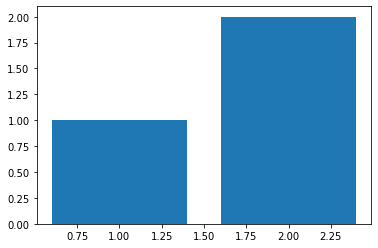

In [595]:
plt.bar([1,2], [1,2])

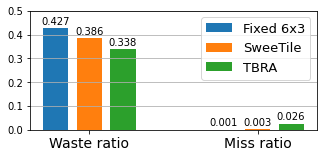

In [23]:
plt.figure(figsize=(4.6, 2.3))
x = np.array([1, 2])
plt.grid(axis='y')
plt.bar(x-0.2, [np.average(waste_ratio['sweet_6x3']), np.average(miss_ratio['sweet_6x3'])], width=0.15, label=r'Fixed 6x3')
plt.text(0.715, np.average(waste_ratio['sweet_6x3'])+0.015, np.round(np.average(waste_ratio['sweet_6x3']), 3))
plt.text(1.715, np.average(miss_ratio['sweet_6x3'])+0.015, np.round(np.average(miss_ratio['sweet_6x3']), 3))
plt.bar(x, [np.average(waste_ratio['sweet']), np.average(miss_ratio['sweet'])], width=0.15, label = 'SweeTile')
plt.text(0.915, np.average(waste_ratio['sweet'])+0.015, np.round(np.average(waste_ratio['sweet']), 3))
plt.text(1.915, np.average(miss_ratio['sweet'])+0.015, np.round(np.average(miss_ratio['sweet']), 3))
plt.bar(x+0.2, [np.average(waste_ratio['sweet_tbra']), np.average(miss_ratio['sweet_tbra'])], width=0.15, label = 'TBRA')
plt.text(1.115, np.average(waste_ratio['sweet_tbra'])+0.015, np.round(np.average(waste_ratio['sweet_tbra']), 3))
plt.text(2.115, np.average(miss_ratio['sweet_tbra'])+0.015, np.round(np.average(miss_ratio['sweet_tbra']), 3))
plt.legend(fontsize=13)
plt.ylim(0, 0.5)
plt.xticks(x, ['Waste ratio', 'Miss ratio'], fontsize=14)
plt.tight_layout()
plt.savefig("waste_miss.pdf", bbox_inches='tight')

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


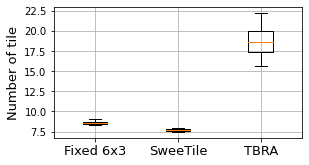

In [9]:
plt.figure(figsize=(4.4, 2.4))
plt.boxplot([tile_count[sche] for sche in ['sweet_6x3', 'sweet', 'sweet_tbra']], \
            sym='', whis=[5, 95], labels = ['Fixed 6x3', 'SweeTile', 'TBRA'])
plt.xticks(fontsize=13)
plt.ylabel('Number of tile', fontsize=13)
plt.yticks(np.arange(7.5, 25, 2.5))
plt.grid()
plt.tight_layout()
plt.savefig('tile.pdf', bbox_inches='tight')

<BarContainer object of 3 artists>

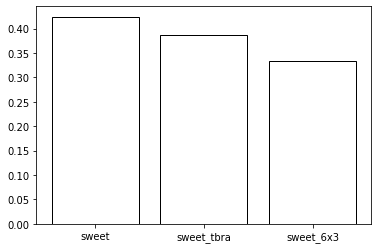

In [602]:
plt.bar(scheme, [np.average(waste_ratio[sche]) for sche in ['sweet_6x3', 'sweet', 'sweet_tbra']], color='w', edgecolor='k')

In [16]:
[np.average(tile_count[sche]) for sche in ['sweet_6x3', 'sweet', 'sweet_tbra']]

[8.60163943693821, 7.72941375996382, 18.683272089999438]

In [17]:
1 - np.average(tile_count['sweet']) / np.average(tile_count['sweet_6x3'])

0.10140225980977213

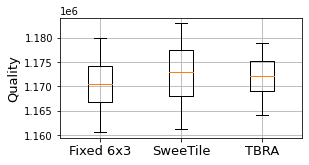

In [46]:
plt.figure(figsize=(4.4, 2.4))
plt.boxplot([bandwidth[sche] for sche in ['sweet_6x3', 'sweet', 'sweet_tbra']], \
            sym='', whis=[5, 95], labels = ['Fixed 6x3', 'SweeTile', 'TBRA'])
plt.xticks(fontsize=13)
plt.ylabel('Quality', fontsize=13)
plt.grid()
plt.tight_layout()
plt.savefig('psnr.pdf', bbox_inches='tight')

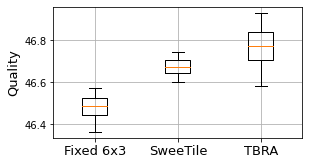

In [30]:
plt.figure(figsize=(4.4, 2.4))
plt.boxplot([actual_Q1[sche] for sche in ['sweet_6x3', 'sweet', 'sweet_tbra']], \
            sym='', whis=[5, 95], labels = ['Fixed 6x3', 'SweeTile', 'TBRA'])
plt.xticks(fontsize=13)
plt.ylabel('Quality', fontsize=13)
plt.grid()
plt.tight_layout()
plt.savefig('psnr.pdf', bbox_inches='tight')

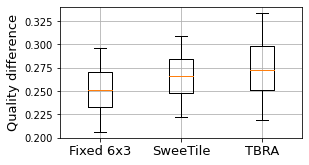

In [29]:
plt.figure(figsize=(4.4, 2.4))
plt.boxplot([actual_Q2[sche] for sche in ['sweet_6x3', 'sweet', 'sweet_tbra']], \
            sym='', whis=[5, 95], labels = ['Fixed 6x3', 'SweeTile', 'TBRA'])
plt.xticks(fontsize=13)
plt.ylabel('Quality difference', fontsize=13)
plt.grid()
plt.tight_layout()
plt.savefig('diff.pdf', bbox_inches='tight')

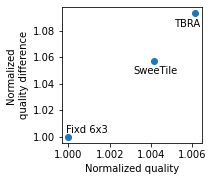

In [47]:
plt.figure(figsize=(2.5, 2.5))
ax = plt.axes()
x = [np.mean(actual_Q1[sche]) / np.mean(actual_Q1['sweet_6x3']) for sche in ['sweet_6x3', 'sweet', 'sweet_tbra']]
y = [np.mean(actual_Q2[sche]) / np.mean(actual_Q2['sweet_6x3']) for sche in ['sweet_6x3', 'sweet', 'sweet_tbra']]
plt.scatter(x, y)
plt.xlabel("Normalized quality")
plt.ylabel("Normalized \nquality difference")
ax.annotate('Fixd 6x3', (x[0]-0.0001, y[0]+0.003))
ax.annotate('SweeTile', (x[1]-0.001, y[1]-0.01))
ax.annotate('TBRA', (x[2]-0.001, y[2]-0.01))
plt.savefig('imp.pdf', bbox_inches='tight')

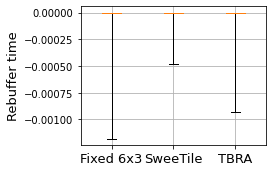

In [27]:
plt.figure(figsize=(3.9, 2.5))
plt.boxplot([rebuffer_time[sche] for sche in ['sweet_6x3', 'sweet', 'sweet_tbra']], \
            sym='', whis=[5, 95], labels = ['Fixed 6x3', 'SweeTile', 'TBRA'])
plt.xticks(fontsize=13)
plt.ylabel('Rebuffer time', fontsize=13)
plt.grid()
plt.tight_layout()
plt.savefig('rebuf.pdf', bbox_inches='tight')

In [ ]:
plt.figure(figsize=(3.6, 2.7))
plt.boxplot([actual_Q1[sche] for sche in ['sweet_6x3', 'sweet', 'sweet_tbra']], \
            sym='', whis=[5, 95], labels = ['Fix 6x3', 'SweeTile', 'TBRA'])
plt.xticks(fontsize=13)
plt.ylabel('Number of tile', fontsize=13)
plt.grid()

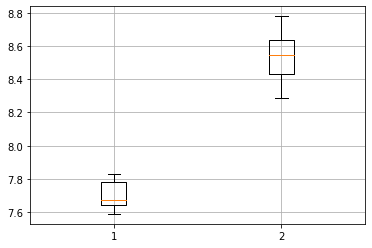

In [567]:
plt.boxplot([tile_count['sweet'], tile_count['sweet_6x3']], sym='', whis=[5, 95])
plt.grid()

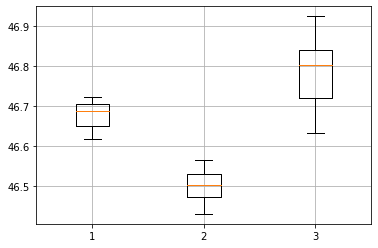

In [568]:
plt.boxplot([actual_Q1['sweet'], actual_Q1['sweet_6x3'], actual_Q1['sweet_tbra']], sym='', whis=[5, 95])
plt.grid()

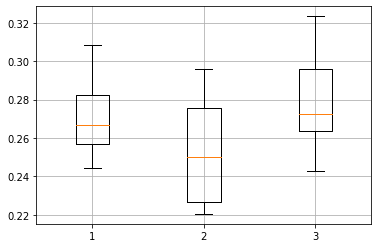

In [569]:
plt.boxplot([actual_Q2['sweet'], actual_Q2['sweet_6x3'], actual_Q2['sweet_tbra']], sym='', whis=[5, 95])
plt.grid()

In [116]:
for sche in scheme:
    print(sche)
    print("waste: ", np.average(waste_ratio[sche]))
    print("Q1: ", np.average(actual_Q1[sche]))
    print("band: ", np.average(bandwidth[sche]))
    print("tile: ", np.average(tile_count[sche]))

sweet_tbra
waste:  0.4543432980135124
Q1:  49.79969729957236
band:  1180962.1495288073
tile:  17.940054682159946
sweet_6x3
waste:  0.5180947780309191
Q1:  49.80241622583858
band:  1193635.797143131
tile:  8.527502157031924
sweet_7x7
waste:  0.45595617475565664
Q1:  49.79985105694487
band:  1185802.2385155438
tile:  17.119851258581235
sweet_10x10
waste:  0.39380219023330343
Q1:  49.79688511424556
band:  1181756.7669172932
tile:  28.034774436090224


In [8]:
rebuffer_time

{'sweet': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  -0.0009299520867181785,
  0.0,
  -0.0006225808446652109,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  -1.2684380527511781e-05,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  -0.0003210014255578936,
  0.0,
  0.0,
  0.0,
  -0.00021058041234068818,
  0.0,
  -0.0019538540054276307,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  -0.003974853959925173,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  -0.0003220653576544353,
  0.0,
  0.0,
  -1.5521464655415526e-05,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  -0.000653417570015029,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  

In [67]:
center_count

{'sweet': [2.4,
  2.221052631578947,
  2.6736842105263157,
  2.7263157894736842,
  2.8210526315789473,
  2.7157894736842105,
  2.4105263157894736,
  2.8105263157894735,
  2.8526315789473684,
  2.7578947368421054,
  2.831578947368421,
  2.7157894736842105,
  2.442105263157895,
  2.6842105263157894,
  2.6931818181818183],
 'sweet_10x10': [8.48421052631579,
  8.505263157894737,
  8.126315789473685,
  8.294736842105262,
  8.736842105263158,
  7.989473684210527,
  8.126315789473685,
  8.652631578947368,
  8.021052631578947,
  8.76923076923077,
  7.926315789473684,
  8.778947368421052,
  8.336842105263157,
  8.726315789473684,
  9.147368421052631,
  8.378947368421052,
  8.0],
 'sweet_6x3': [3.0, 2.231578947368421, 2.442105263157895],
 'sweet_7x7': [5.6,
  5.463157894736842,
  5.894736842105263,
  5.5473684210526315,
  5.631578947368421,
  5.726315789473684,
  5.810526315789474,
  5.88421052631579,
  5.431578947368421,
  6.105263157894737,
  5.631578947368421,
  5.6,
  5.389473684210526,
  5.

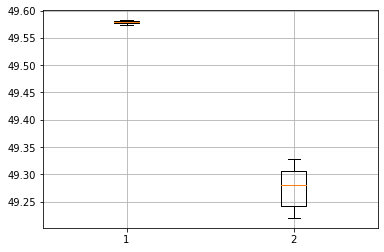

In [20]:
plt.boxplot([actual_Q1['sweet'], actual_Q1['sweet_tbra']], sym='', whis=[5, 95])
plt.grid()

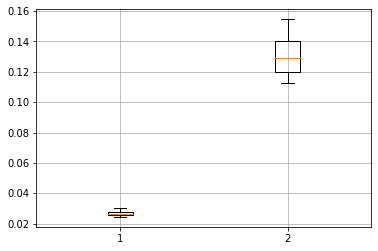

In [21]:
plt.boxplot([actual_Q2['sweet'], actual_Q2['sweet_tbra']], sym='', whis=[5, 95])
plt.grid()

In [68]:
tile_count

{'sweet': [7.663157894736842,
  7.410526315789474,
  7.852631578947369,
  7.673684210526316,
  7.7894736842105265,
  7.652631578947369,
  7.6,
  7.7368421052631575,
  7.831578947368421,
  7.631578947368421,
  7.7894736842105265,
  7.7894736842105265,
  7.778947368421052,
  7.589473684210526,
  7.715909090909091],
 'sweet_10x10': [27.894736842105264,
  28.442105263157895,
  27.94736842105263,
  28.189473684210526,
  28.873684210526317,
  27.673684210526314,
  27.726315789473684,
  27.91578947368421,
  27.936842105263157,
  29.17948717948718,
  27.57894736842105,
  28.91578947368421,
  27.526315789473685,
  28.68421052631579,
  28.852631578947367,
  27.568421052631578,
  27.557894736842105],
 'sweet_6x3': [8.416666666666666, 8.389473684210527, 8.463157894736842],
 'sweet_7x7': [17.326315789473686,
  16.568421052631578,
  17.357894736842105,
  16.45263157894737,
  17.757894736842104,
  16.221052631578946,
  17.589473684210525,
  17.442105263157895,
  17.431578947368422,
  17.9157894736842

In [131]:
actual_Q1

{'sweet': [-inf,
  0.5214924504023692,
  0.5215128919349176,
  0.5218206069120962,
  -inf,
  0.521453625963487,
  -inf,
  0.5218562473011498,
  0.521453625963487,
  0.5209248228378615,
  -inf,
  0.521460682500329,
  0.521460682500329,
  0.520607725539157,
  0.5218667090529922,
  0.521460682500329,
  -inf,
  0.5218174097739212,
  0.521460682500329],
 'sweet_10x10': [-inf,
  -inf,
  -inf,
  -inf,
  -inf,
  -inf,
  -inf,
  -inf,
  -inf,
  -inf,
  -inf,
  -inf,
  -inf,
  -inf,
  -inf,
  -inf,
  -inf,
  -inf,
  -inf],
 'sweet_6x3': [0.5211846981280206,
  0.5210710008288815,
  0.521369459220068,
  -inf,
  -inf,
  0.5214751547730759,
  -inf,
  -inf,
  -inf,
  0.520607725539157,
  -inf,
  0.5214547039750135,
  0.521382479977651,
  -inf,
  0.5211801621894155,
  0.520607725539157,
  0.520607725539157,
  -inf,
  0.5213738121563962],
 'sweet_7x7': [-inf,
  0.518130426579507,
  -inf,
  0.5176007732615783,
  0.5181634250785572,
  0.517906666261544,
  -inf,
  -inf,
  -inf,
  -inf,
  0.518031020675171

In [132]:
actual_Q2

{'sweet': [inf,
  1.0540804848558527,
  1.0541218028471737,
  1.0547437799287052,
  inf,
  1.054002009926197,
  inf,
  1.0548158190129624,
  1.054002009926197,
  1.0529331525446137,
  inf,
  1.0540162731389626,
  1.0540162731389626,
  1.0522922111961683,
  1.0548369651071117,
  1.0540162731389626,
  inf,
  1.0547373176281385,
  1.0540162731389626],
 'sweet_10x10': [inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  inf],
 'sweet_6x3': [1.0534584323864244,
  1.0532286186966753,
  1.0538318856575843,
  inf,
  inf,
  1.0540455256051535,
  inf,
  inf,
  inf,
  1.0522922111961683,
  inf,
  1.0540041888856655,
  1.0538582042101454,
  inf,
  1.0534492639998825,
  1.0522922111961683,
  1.0522922111961683,
  inf,
  1.0538406841459071],
 'sweet_7x7': [inf,
  1.0472849047883654,
  inf,
  1.0462143289329775,
  1.0473516038821902,
  1.0468326232946101,
  inf,
  inf,
  inf,
  inf,
  1.047083977960454,
  inf,
  1.0471716267053

In [81]:
#perturb = ['11']
for sche in scheme:
    for _ in range(1):
        record[sche] = {}
        print(sche)
        for index in user_video_pair[sche]:
            #if int(index[2]) > 8:
            #    continue
            start = 0
            end = -1
            
            for t, s in enumerate(df['S'][index[0]][index[1]][index[2]][index[3]][0]):
                if s == -1:
                    end = t
                    break
            if end == -1:
                end = 95

            print(end, end=' ')
            
            if end-W_max <= start:
                continue
            
            w = 1
            qoe = []
            waste = []
            miss = []
            error = []
            payload = []
            waste_payload = []
            #waste_resource = []
            for t in range(start, end):
                x = df["X"][index[0]][index[1]][index[2]][index[3]][0][:,:,t]
                ground = df["ground_beta"][index[0]][index[1]][index[2]][index[3]][0][t,:,:]
                qoe.append(np.sum(x * ground))
                waste.append(np.sum(np.logical_and(x != 0., ground == 0.)))
                miss.append(np.sum(np.logical_and(x == 0., ground != 0.)))

                if t+w+1 >= end:
                    continue
                p1 = df['ground'][index[0]][index[1]][index[2]][index[3]][0][t+w+1]
                p1 = xyz_to_eqr(p1[0], p1[1], p1[2])
                p2 = df['prediction'][index[0]][index[1]][index[2]][index[3]][0][t][w]
                p2 = xyz_to_eqr(p2[0], p2[1], p2[2])
                error.append(distance(p1[0], p1[1], p2[0], p2[1]))
                
                pay = np.sum(x[:,[1,2]]) + 0.5 * np.sum(x[:,[0,3]])
                payload.append(pay)
                was = np.logical_and(x != 0., ground == 0.)
                if pay == 0:
                    waste_payload.append(0)
                else:
                    waste_payload.append((np.sum(was[:, [1,2]]) + 0.5 * np.sum(was[:, [0,3]]))/pay)
                
                #all_resource = 0
                #used_resource = 0
                #for n, v in df["action_table"][index[0]][index[1]][index[2]][index[3]][0][t].items():
                #    all_resource += v
                #    if df["ground_beta"][index[0]][index[1]][index[2]][index[3]][0][t+n[2]][n[0]][n[1]]:
                #        used_resource += v
                #waste_resource.append(1 - used_resource / all_resource)

            record[(sche, B)][index] = [np.mean(qoe), np.mean(waste), np.mean(miss), np.mean(error), \
                                        np.mean(waste_payload)]
#perturb = ['11', '44', '00', '80']

result_indoor_dash_00 350
95 95 95 95 95 95 95 95 95 95 95 95 95 95 35 95 95 95 95 95 95 25 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 15 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 45 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 25 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 85 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 result_flare_00 400
95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 45 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95 95

In [82]:
scheme = ['result_indoor_dash_00', 'result_flare_00', 'result_indoor_enhance_00']
B_lookup = [400, 450, 500, 550, 600]

In [66]:
scheme = ['result_flare_00']
B_lookup = [400, 450, 550, 600]

In [39]:
scheme = ['result_flare_00']
B_lookup = [600]

In [83]:
for sche in scheme:
    for B in B_lookup:
        print(sche, B)
        print(len(record[(sche, B)]))

result_indoor_dash_00 400
450
result_indoor_dash_00 450
480
result_indoor_dash_00 500
847
result_indoor_dash_00 550
760
result_indoor_dash_00 600
760
result_flare_00 400
226
result_flare_00 450
224
result_flare_00 500
785
result_flare_00 550
224
result_flare_00 600
760
result_indoor_enhance_00 400
76
result_indoor_enhance_00 450
76
result_indoor_enhance_00 500
380
result_indoor_enhance_00 550
76
result_indoor_enhance_00 600
76


In [84]:
for sche in scheme:
    for B in B_lookup:
        print(sche, B)
        print(len(record[(sche, B)]))

result_indoor_dash_00 400
450
result_indoor_dash_00 450
480
result_indoor_dash_00 500
847
result_indoor_dash_00 550
760
result_indoor_dash_00 600
760
result_flare_00 400
226
result_flare_00 450
224
result_flare_00 500
785
result_flare_00 550
224
result_flare_00 600
760
result_indoor_enhance_00 400
76
result_indoor_enhance_00 450
76
result_indoor_enhance_00 500
380
result_indoor_enhance_00 550
76
result_indoor_enhance_00 600
76


In [85]:
error_plot = [[], [], []]
qoe_plot = [[], [], []]
waste_plot = [[], [], []]
waste_payload_plot = [[], [], []]
miss_plot = [[], [], []]
for i, sche in enumerate(scheme):
    for B in B_lookup:
        tmp = np.mean(list(record[(sche, B)].values()), axis=0)
        qoe_plot[i].append(tmp[0])
        waste_plot[i].append(tmp[1])
        miss_plot[i].append(tmp[2])
        error_plot[i].append(tmp[3])
        waste_payload_plot[i].append(tmp[4])
        #error_scheme[i].append(np.mean(list(error_record[(sche, pert)].values())))  

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [99]:
qoe_plot

[[0.7235644737874567,
  0.7844739032849186,
  0.8194899173704807,
  0.8331296884771231],
 [0.6672156092915796,
  0.7963417085007428,
  0.8300685633464628,
  0.845158989068473],
 [0.8116881215375958,
  0.9078893790766249,
  0.9396101440794197,
  0.9523401253955448]]

In [31]:
waste_resource_plot

[[0.08125786953772864,
  0.14434125723085933,
  0.18138474535603558,
  0.12222546493723539,
  0.3103825952109094,
  0.23524006299995964,
  0.3045270886826417],
 [0.04613315128619146,
  0.10576077643125417,
  0.15007501624080336,
  0.1175951857768096,
  0.19209759463791623,
  0.1787155258059026,
  0.22616173758001407],
 [0.0375582805152367,
  0.10772887038559323,
  0.15284987746961703,
  0.20604196847842443,
  0.19443389521460325,
  0.25208521100077236,
  0.2803750478108366]]

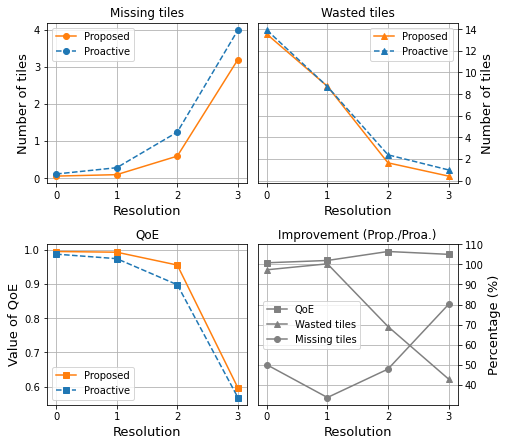

In [132]:
fig, axs = plt.subplots(2,2)
fig.set_size_inches(4*1.8, 4.5*1.4)
axs[0][0].plot(miss_plot[0], marker='o', linestyle='-', color='C1', label='Proposed')
axs[0][0].plot(miss_plot[1], marker='o', linestyle='--', color='C0', label='Proactive')
axs[0][1].yaxis.tick_right()
axs[0][1].yaxis.set_label_position("right")
axs[0][1].plot(waste_plot[0], marker='^', linestyle='-', color='C1', label='Proposed')
axs[0][1].plot(waste_plot[1], marker='^', linestyle='--', color='C0', label='Proactive')
axs[1][0].plot(qoe_plot[0], marker='s', linestyle='-', color='C1', label='Proposed')
axs[1][0].plot(qoe_plot[1], marker='s', linestyle='--', color='C0', label='Proactive')
axs[1][1].yaxis.tick_right()
axs[1][1].yaxis.set_label_position("right")
axs[1][1].plot(100*(np.array(qoe_plot[0]) / np.array(qoe_plot[1])), marker='s', linestyle='-', color='gray', label='QoE')
axs[1][1].plot(100*(np.array(waste_plot[0]) / np.array(waste_plot[1])), marker='^', linestyle='-', color='gray', label='Wasted tiles')
axs[1][1].plot(100*(np.array(miss_plot[0]) / np.array(miss_plot[1])), marker='o', linestyle='-', color='gray', label='Missing tiles')

axs[0][0].set_title('Missing tiles')
axs[0][1].set_title('Wasted tiles')
axs[1][0].set_title('QoE')
axs[1][1].set_title('Improvement (Prop./Proa.)')
axs[1][0].set_ylabel('Value of QoE', fontsize=13)
axs[1][1].set_ylabel('Percentage (%)', fontsize=13)
pos = [[2, 0], [0, 0]]
for i in range(2):
    axs[0][i].set_ylabel('Number of tiles', fontsize=13)
    #axs[0][i].set_yticks(np.arange(0, 5, 1))
    #axs[0][i].set_ylim(-0.2, 4.2)
    for j in range(2):
        axs[i][j].grid()
        axs[i][j].legend(loc=pos[i][j])
        axs[i][j].set_xlabel('Resolution', fontsize=13)
fig.tight_layout()

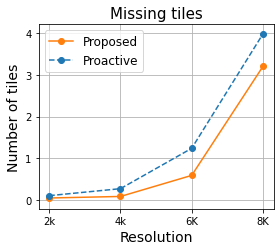

In [31]:
fig, axs = plt.subplots()
#fig.set_size_inches(3.6, 4.2)
fig.set_size_inches(4.0, 3.6)
reso = ['2k', '4k', '6K', '8K']
axs.plot(reso, miss_plot[0], marker='o', linestyle='-', color='C1', label='Proposed')
axs.plot(reso, miss_plot[1], marker='o', linestyle='--', color='C0', label='Proactive')

axs.set_title('Missing tiles', fontsize=15)
pos = 2
axs.set_ylabel('Number of tiles', fontsize=14)
axs.set_yticks(np.arange(0, 5, 1))
axs.set_ylim(-0.2, 4.2)
axs.grid()
axs.legend(loc=pos, fontsize=12)
axs.set_xlabel('Resolution', fontsize=14)
fig.tight_layout()
plt.savefig("reso_miss.png")
plt.savefig("reso_miss.pdf")

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


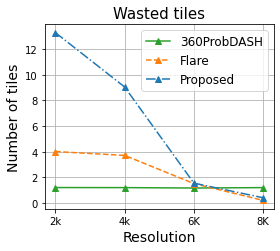

In [18]:
fig, axs = plt.subplots()
#fig.set_size_inches(3.6, 4.2)
fig.set_size_inches(4.0, 3.6)
reso = ['2k', '4k', '6K', '8K']
axs.plot(reso, waste_plot[0], marker='^', linestyle='-', color='C2', label='360ProbDASH')
axs.plot(reso, waste_plot[1], marker='^', linestyle='--', color='C1', label='Flare')
axs.plot(reso, waste_plot[2], marker='^', linestyle='-.', color='C0', label='Proposed')

axs.set_title('Wasted tiles', fontsize=15)
pos = 0
axs.set_ylabel('Number of tiles', fontsize=14)
#axs.set_yticks(np.arange(0, 5, 1))
#axs.set_ylim(-0.2, 4.2)
axs.grid()
axs.legend(fontsize=12)
axs.set_xlabel('Resolution', fontsize=14)
fig.tight_layout()
plt.savefig("reso_waste.png")
plt.savefig("reso_waste.pdf")

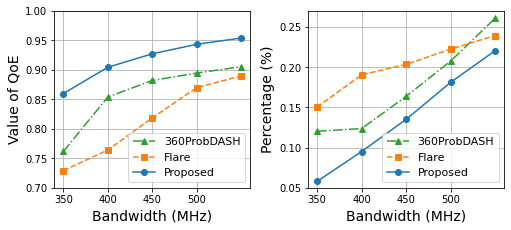

In [11]:
fig, axs = plt.subplots(1, 2)
#fig.set_size_inches(3.6, 4.2)
#fig.set_size_inches(4.0, 7.2)
fig.set_size_inches(7.2, 3.3)
axs[0].plot(B_lookup, qoe_plot[0], marker='^', linestyle='-.', color='C2', label='360ProbDASH')
axs[0].plot(B_lookup, qoe_plot[1], marker='s', linestyle='--', color='C1', label='Flare')
axs[0].plot(B_lookup, qoe_plot[2], marker='o', linestyle='-', color='C0', label='Proposed')
#axs[0].set_title('(a) QoE', fontsize=15)
axs[0].set_ylabel('Value of QoE', fontsize=14)
axs[0].set_ylim(0.7,1)
axs[0].set_yticks(np.arange(0.7, 1.0, 0.05))
axs[0].grid()
axs[0].legend(loc=0, fontsize=11)
axs[0].set_xlabel('Bandwidth (MHz)', fontsize=14)
axs[0].set_xticks(np.arange(350, 550, 50))

axs[1].plot(B_lookup, waste_payload_plot[0], marker='^', linestyle='-.', color='C2', label='360ProbDASH')
axs[1].plot(B_lookup, waste_payload_plot[1], marker='s', linestyle='--', color='C1', label='Flare')
axs[1].plot(B_lookup, waste_payload_plot[2], marker='o', linestyle='-', color='C0', label='Proposed')
#axs[1].set_title('(b) Wasted payload', fontsize=15)
axs[1].set_ylabel('Percentage (%)', fontsize=14)
axs[1].set_ylim(0.05,0.27)
axs[1].grid()
axs[1].legend(loc=4, fontsize=11)
axs[1].set_xlabel('Bandwidth (MHz)', fontsize=14)
axs[1].set_xticks(np.arange(350, 550, 50))
#axs[1].text(430, -0.12, "(b)", fontsize=16)

fig.tight_layout()
plt.savefig("band_qoe_payload.png")
plt.savefig("band_qoe_payload.pdf")

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


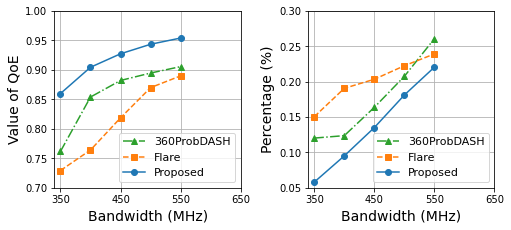

In [9]:
fig, axs = plt.subplots(1, 2)
#fig.set_size_inches(3.6, 4.2)
#fig.set_size_inches(4.0, 7.2)
fig.set_size_inches(7.2, 3.3)
axs[0].plot(B_lookup, qoe_plot[0], marker='^', linestyle='-.', color='C2', label='360ProbDASH')
axs[0].plot(B_lookup, qoe_plot[1], marker='s', linestyle='--', color='C1', label='Flare')
axs[0].plot(B_lookup, qoe_plot[2], marker='o', linestyle='-', color='C0', label='Proposed')
#axs[0].set_title('(a) QoE', fontsize=15)
axs[0].set_ylabel('Value of QoE', fontsize=14)
axs[0].set_ylim(0.7,1)
axs[0].set_yticks(np.arange(0.7, 1.0, 0.05))
axs[0].grid()
axs[0].legend(loc=0, fontsize=11)
axs[0].set_xlabel('Bandwidth (MHz)', fontsize=14)
axs[0].set_xticks(np.arange(350, 700, 100))

axs[1].plot(B_lookup, waste_payload_plot[0], marker='^', linestyle='-.', color='C2', label='360ProbDASH')
axs[1].plot(B_lookup, waste_payload_plot[1], marker='s', linestyle='--', color='C1', label='Flare')
axs[1].plot(B_lookup, waste_payload_plot[2], marker='o', linestyle='-', color='C0', label='Proposed')
#axs[1].set_title('(b) Wasted payload', fontsize=15)
axs[1].set_ylabel('Percentage (%)', fontsize=14)
axs[1].set_ylim(0.05,0.3)
axs[1].grid()
axs[1].legend(loc=4, fontsize=11)
axs[1].set_xlabel('Bandwidth (MHz)', fontsize=14)
axs[1].set_xticks(np.arange(350, 700, 100))
#axs[1].text(430, -0.12, "(b)", fontsize=16)

fig.tight_layout()
plt.savefig("band_qoe_payload.png")
plt.savefig("band_qoe_payload.pdf")

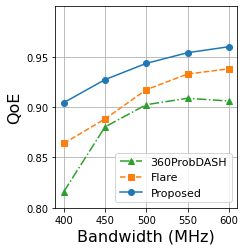

In [87]:
fig, axs = plt.subplots(1, 1)
#fig.set_size_inches(3.6, 4.2)
#fig.set_size_inches(4.0, 7.2)
fig.set_size_inches(3.5, 3.6)
axs.plot(B_lookup, qoe_plot[0], marker='^', linestyle='-.', color='C2', label='360ProbDASH')
axs.plot(B_lookup, qoe_plot[1], marker='s', linestyle='--', color='C1', label='Flare')
axs.plot(B_lookup, qoe_plot[2], marker='o', linestyle='-', color='C0', label='Proposed')
#axs[0].set_title('(a) QoE', fontsize=15)
axs.set_ylabel('QoE', fontsize=16)
axs.set_ylim(0.8,1)
axs.set_yticks(np.arange(0.8, 1.0, 0.05))
axs.grid()
axs.legend(loc=0, fontsize=11)
axs.set_xlabel('Bandwidth (MHz)', fontsize=16)
axs.set_xticks(np.arange(400, 650, 50))

fig.tight_layout()
plt.savefig("band_qoe.png")
plt.savefig("band_qoe.pdf")

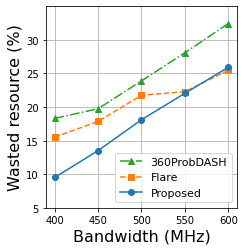

In [86]:
fig, axs = plt.subplots(1, 1)
#fig.set_size_inches(3.6, 4.2)
#fig.set_size_inches(4.0, 7.2)
fig.set_size_inches(3.5, 3.6)

axs.plot(B_lookup, [p*100 for p in waste_payload_plot[0]], marker='^', linestyle='-.', color='C2', label='360ProbDASH')
axs.plot(B_lookup, [p*100 for p in waste_payload_plot[1]], marker='s', linestyle='--', color='C1', label='Flare')
axs.plot(B_lookup, [p*100 for p in waste_payload_plot[2]], marker='o', linestyle='-', color='C0', label='Proposed')
#axs[1].set_title('(b) Wasted payload', fontsize=15)
axs.set_ylabel('Wasted resource (%)', fontsize=16)
axs.set_ylim(5,35)
axs.set_yticks(np.arange(5, 35, 5))
axs.grid()
axs.legend(loc=4, fontsize=11)
axs.set_xlabel('Bandwidth (MHz)', fontsize=16)
axs.set_xticks(np.arange(400, 650, 50))
#axs[1].text(430, -0.12, "(b)", fontsize=16)

fig.tight_layout()
plt.savefig("band_payload.png")
plt.savefig("band_payload.pdf")

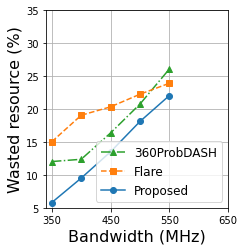

In [16]:
figfig, axs = plt.subplots(1, 1)
#fig.set_size_inches(3.6, 4.2)
#fig.set_size_inches(4.0, 7.2)
fig.set_size_inches(3.5, 3.6)

axs.plot(B_lookup, [p*100 for p in waste_payload_plot[0]], marker='^', linestyle='-.', color='C2', label='360ProbDASH')
axs.plot(B_lookup, [p*100 for p in waste_payload_plot[1]], marker='s', linestyle='--', color='C1', label='Flare')
axs.plot(B_lookup, [p*100 for p in waste_payload_plot[2]], marker='o', linestyle='-', color='C0', label='Proposed')
#axs[1].set_title('(b) Wasted payload', fontsize=15)
axs.set_ylabel('Wasted resource (%)', fontsize=16)
axs.set_ylim(5,35)
axs.grid()
axs.legend(loc=4, fontsize=12)
axs.set_xlabel('Bandwidth (MHz)', fontsize=16)
axs.set_xticks(np.arange(350, 700, 100))
#axs[1].text(430, -0.12, "(b)", fontsize=16)

fig.tight_layout()
plt.savefig("band_payload.png")
plt.savefig("band_payload.pdf")

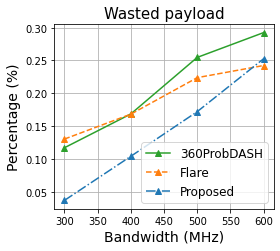

In [48]:
fig, axs = plt.subplots()
#fig.set_size_inches(3.6, 4.2)
fig.set_size_inches(4.0, 3.6)
axs.plot(B_lookup, waste_payload_plot[0], marker='^', linestyle='-', color='C2', label='360ProbDASH')
axs.plot(B_lookup, waste_payload_plot[1], marker='^', linestyle='--', color='C1', label='Flare')
axs.plot(B_lookup, waste_payload_plot[2], marker='^', linestyle='-.', color='C0', label='Proposed')

axs.set_title('Wasted payload', fontsize=15)
axs.set_ylabel('Percentage (%)', fontsize=14)
pos = 4
axs.grid()
axs.legend(loc=pos, fontsize=12)
axs.set_xlabel('Bandwidth (MHz)', fontsize=14)
fig.tight_layout()
plt.savefig("band_payload.png")
plt.savefig("band_payload.pdf")

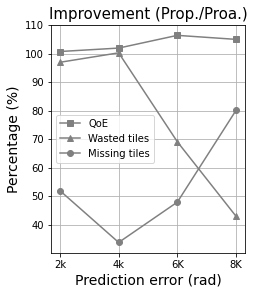

In [126]:
fig, axs = plt.subplots()
fig.set_size_inches(3.6, 4.2)
axs.plot(reso, 100*(np.array(qoe_plot[0]) / np.array(qoe_plot[1])), marker='s', linestyle='-', color='gray', label='QoE')
axs.plot(reso, 100*(np.array(waste_plot[0]) / np.array(waste_plot[1])), marker='^', linestyle='-', color='gray', label='Wasted tiles')
axs.plot(reso, 100*(np.array(miss_plot[0]) / np.array(miss_plot[1])), marker='o', linestyle='-', color='gray', label='Missing tiles')

axs.set_title('Improvement (Prop./Proa.)', fontsize=15)
axs.set_ylabel('Percentage (%)', fontsize=14)
pos = 0
axs.grid()
axs.legend(loc=pos, fontsize=10)
axs.set_xlabel('Prediction error (rad)', fontsize=14)
fig.tight_layout()
plt.savefig("reso_imp.png")
plt.savefig("reso_imp.pdf")

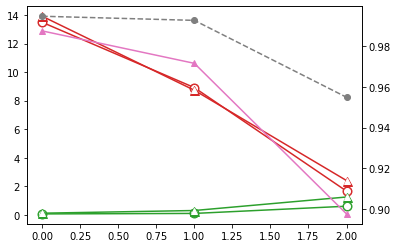

In [56]:
ax = plt.gca()
twin = ax.twinx()
ax.plot(waste_plot[0], marker='o', markersize=9, linestyle='-', color='C3')
ax.plot(waste_plot[0], 'o', color='w')
ax.plot(waste_plot[1], marker='^', markersize=9, linestyle='-', color='C3')
ax.plot(waste_plot[1], '^', color='w')
ax.plot(miss_plot[0], marker='o', markersize=9, linestyle='-', color='C2')
ax.plot(miss_plot[0], 'o', color='w')
ax.plot(miss_plot[1], marker='^', markersize=9, linestyle='-', color='C2')
ax.plot(miss_plot[1], '^', color='w')
twin.plot(qoe_plot[1], marker='^', linestyle='-', color='C6')
twin.plot(qoe_plot[0], marker='o', linestyle='--', color='C7')
#twin.plot(error_plot[0], miss_plot[1], marker='^', linestyle='--', color='C8')
#ax.set_ylim(0, 4)

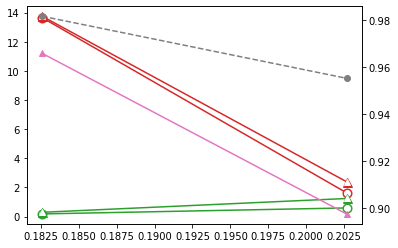

In [8]:
ax = plt.gca()
twin = ax.twinx()
ax.plot(error_plot[0], waste_plot[0], marker='o', markersize=9, linestyle='-', color='C3')
ax.plot(error_plot[0], waste_plot[0], 'o', color='w')
ax.plot(error_plot[0], waste_plot[1], marker='^', markersize=9, linestyle='-', color='C3')
ax.plot(error_plot[0], waste_plot[1], '^', color='w')
ax.plot(error_plot[0], miss_plot[0], marker='o', markersize=9, linestyle='-', color='C2')
ax.plot(error_plot[0], miss_plot[0], 'o', color='w')
ax.plot(error_plot[0], miss_plot[1], marker='^', markersize=9, linestyle='-', color='C2')
ax.plot(error_plot[0], miss_plot[1], '^', color='w')
twin.plot(error_plot[0], qoe_plot[1], marker='^', linestyle='-', color='C6')
twin.plot(error_plot[0], qoe_plot[0], marker='o', linestyle='--', color='C7')
#twin.plot(error_plot[0], miss_plot[1], marker='^', linestyle='--', color='C8')
#ax.set_ylim(0, 4)

In [26]:
for i in range(len(qoe_plot[0])):
    print(qoe_plot[0][i] / qoe_plot[1][i])
print(qoe_plot)

1.0076744398090502
1.0191600920512804
1.0636369620108939
1.046144844353709
[[0.9944003787582566, 0.9925792493928516, 0.9546125515338503, 0.5979412911757336], [0.9868270340832411, 0.9739188741143413, 0.8974984751649435, 0.5715664464657682]]


In [27]:
for i in range(len(qoe_plot[0])):
    print(1-miss_plot[0][i] / miss_plot[1][i])
print(miss_plot)

0.4944090909090909
0.6630820693673873
0.5198265105620599
0.19527493827032982
[[0.057323232323232325, 0.09426129426129413, 0.5961353995621235, 3.1924370659722214], [0.11337868480725623, 0.2797752380952381, 1.241500025875899, 3.96711525189786]]


In [28]:
for i in range(len(qoe_plot[0])):
    print(1-waste_payload_plot[0][i] / waste_payload_plot[1][i])
print(waste_payload_plot)

0.013952476984469664
0.0065915696630444165
0.3149954402443307
0.5771279166368133
[[0.5624734676733824, 0.43780623800254487, 0.14158472585768092, 0.0599719371740361], [0.5704324127839459, 0.44071121668863306, 0.20669165459012717, 0.14182051625888195]]


In [29]:
for i in range(len(qoe_plot[0])):
    print(1-waste_plot[0][i] / waste_plot[1][i])
print(waste_plot)

0.026013214944512697
-0.005879143337514048
0.3011643102205972
0.5748864265972766
[[13.540404040404042, 8.742263600596935, 1.6682820557139986, 0.4252712673611112], [13.902040816326533, 8.691166984126983, 2.3872307612689543, 1.0003709454796412]]


In [67]:
for sche in scheme:
    for pert in perturb:
        print(sche, pert)
        print(len(qoe_record[(sche, pert)]))
        print(np.mean(list(qoe_record[(sche, pert)].values())))
        print(np.mean(list(error_record[(sche, pert)].values())))

best 00
43
0.9550122495218077
0.5194289109707327
best 04
54
0.9132380853466974
0.5368041414347693
best 06
57
0.8810845955639104
nan
pro 00
43
0.8962203689599347
0.5015237580077546
pro 04
50
0.8003919658243166
0.5312734072084665
pro 06
54
0.7487554184575033
0.541923633593616


In [76]:
[[k, qoe_record[k]] for k in sorted(qoe_record, key=qoe_record.get)]

[[('5', '0', '6_DroneFlight'), 0.7155201965878993],
 [('5', '12', '4_Ocean'), 0.8190300401594438],
 [('5', '8', '5_Waterpark'), 0.8516253745342115],
 [('5', '12', '6_DroneFlight'), 0.8663427667961748],
 [('5', '0', '2_Diner'), 0.8701995936877508],
 [('5', '16', '6_DroneFlight'), 0.8754448259596369],
 [('5', '4', '3_PlanEnergyBioLab'), 0.8800232408557956],
 [('5', '12', '3_PlanEnergyBioLab'), 0.8837507166865474],
 [('5', '8', '2_Diner'), 0.8879675430539227],
 [('5', '16', '3_PlanEnergyBioLab'), 0.888878025664281],
 [('5', '0', '4_Ocean'), 0.891131754407023],
 [('5', '16', '5_Waterpark'), 0.8974003758983242],
 [('5', '16', '4_Ocean'), 0.8989505709429383],
 [('5', '8', '3_PlanEnergyBioLab'), 0.9019483673703864],
 [('5', '0', '5_Waterpark'), 0.9056999409452229],
 [('5', '12', '2_Diner'), 0.910297931715329],
 [('5', '4', '5_Waterpark'), 0.9151665022409702],
 [('5', '0', '3_PlanEnergyBioLab'), 0.919871285250275],
 [('5', '4', '1_PortoRiverside'), 0.9206111265631409],
 [('5', '8', '4_Ocean'),

In [70]:
_, u, v = sorted(qoe_record, key=qoe_record.get)[-10]
#print(u, v)
#u, v = '45', '17_UnderwaterPark'
#u, v = '8', '4_Ocean'
#u, v = '46', '2_Diner'
#u, v = '36', '17_UnderwaterPark'
#u, v = '25', '8_Sofa'
#u, v = '26', '11_Abbottsford'
user = u
video = v
actual_W = []
count_W = 0

start = 0
end = -1
#print(index)
#print(df['S'][index[0]][index[1]][index[2]][0])
for t, s in enumerate(df['S'][str(W_max)][u][v][0]):
    if s == -1:
        end = t
        break
if end == -1:
    end = 100-W_max

print(end)

width = 50. / 180 * np.pi
height = 45. / 180 * np.pi

for t in range(start, end):
    if len(df['action_table'][str(W_max)][user][video][0][t]) != 0:
        w = max(df['action_table'][str(W_max)][user][video][0][t], key = lambda x: x[-1])[-1]
    else:
        w = 0
    actual_W.append(w)
explo_index = df["exploration_record"][str(W_max)][user][video][0][start:end].nonzero()
explo = [df["exploration_record"][str(W_max)][user][video][0][i+start] for i in explo_index]

prediction_error = [[] for _ in range(W_max)]
for t in range(start, end):
    for w in range(W_max):
        if t+w+1 >= end:
            break
        p1 = df['ground'][str(W_max)][user][video][0][t+w+1]
        p1 = xyz_to_eqr(p1[0], p1[1], p1[2])
        p2 = df['prediction'][str(W_max)][user][video][0][t][w]
        p2 = xyz_to_eqr(p2[0], p2[1], p2[2])
        prediction_error[w].append(distance(p1[0], p1[1], p2[0], p2[1]))

count_index = np.zeros((end-start, W_max+1))
for t in range(start, end):
    for _, _, w in df['action_table'][str(W_max)][user][video][0][t].keys():
        count_index[t-start][w] += 1
for w in range(W_max):
    count_index[:,w+1] += count_index[:,w]
        
qoe = []
pred_qoe = [[] for _ in range(W_max)]
waste = []
missing = []
pred_waste = [[] for _ in range(W_max)]
for t in range(start, end):
    x = df["X"][str(W_max)][user][video][0][:,:,t]
    ground = df["ground_beta"][str(W_max)][user][video][0][t,:,:]
    qoe.append(np.sum(x * ground))
    waste.append(np.sum(np.logical_and(x != 0., ground == 0.)))
    missing.append(np.sum(np.logical_and(x == 0., ground != 0.)))
    '''
    for w in range(W_max):
        pred_viewpoint = df["prediction"][str(W_max)][user][video][0][t][w]
        pred_eqr = xyz_to_eqr(pred_viewpoint[0], pred_viewpoint[1], pred_viewpoint[2])
        V = collect_viewport(pred_eqr[0], pred_eqr[1], width, height, 6, 4)
        tmp = 0.
        tmp2 = 0
        for (i,j) in V:
            tmp += df["ground_beta"][str(W_max)][user][video][0][t, i, j]
            if df["ground_beta"][str(W_max)][user][video][0][t, i, j] == 0.:
                tmp2 += 1
        pred_qoe[w].append(tmp)
        pred_waste[w].append(tmp2)
    '''

95


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94]


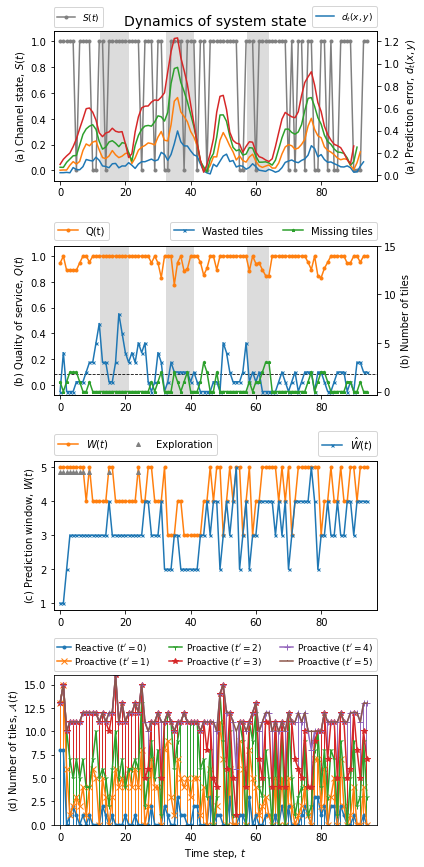

In [71]:
fig, axs = plt.subplots(4)
fig.set_size_inches(4*1.5, 4.5*2.7)
axs[0].set_title('Dynamics of system state', size=14)

twin1 = axs[0].twinx()
axs[0].add_patch(patches.Rectangle((12, -1), 9, 3, edgecolor = 'white', facecolor = 'gainsboro', fill=True))
axs[0].add_patch(patches.Rectangle((32, -1), 9, 3, edgecolor = 'white', facecolor = 'gainsboro', fill=True))
axs[0].add_patch(patches.Rectangle((57, -1), 7, 3, edgecolor = 'white', facecolor = 'gainsboro', fill=True))
axs[0].plot(df['S'][str(W_max)][user][video][0][start:end], color='grey', marker='.', label=r"$S(t)$")
axs[0].set_xlim(-2, end+2)
axs[0].set_ylim(-0.08, 1.08)
axs[0].set(ylabel=r'(a) Channel state, $S(t)$')
for w in range(W_max-1):
    if w == 0:
        twin1.plot(prediction_error[w], label=r"$d_t(x, y)$")
    else:
        twin1.plot(prediction_error[w])
twin1.set(ylabel=r'(a) Prediction error, $d_t(x, y)$')
axs[0].legend(bbox_to_anchor=(0., 1.03), prop={'size': 9}, ncol=1, borderaxespad=0, loc="lower left")
twin1.legend(bbox_to_anchor=(1., 1.03), prop={'size': 9}, ncol=1, borderaxespad=0, loc="lower right")

twin2 = axs[1].twinx()
axs[1].add_patch(patches.Rectangle((12, -1), 9, 3, edgecolor = 'white', facecolor = 'gainsboro', fill=True))
axs[1].add_patch(patches.Rectangle((32, -1), 9, 3, edgecolor = 'white', facecolor = 'gainsboro', fill=True))
axs[1].add_patch(patches.Rectangle((57, -1), 7, 3, edgecolor = 'white', facecolor = 'gainsboro', fill=True))
axs[1].plot(qoe, marker='.', color='C1', markersize=6, label='Q(t)')
axs[1].set_xlim(-2, end+2)
axs[1].set(ylabel=r'(b) Quality of service, $Q(t)$')
axs[1].set_ylim(-0.08, 1.08)
#axs[3].hlines(np.mean(qoe), xmin = 0, xmax = end-W_max-start, linestyle='--', color = 'k')
twin2.plot(waste, marker='x', color='C0', markersize=3, label='Wasted tiles')
twin2.plot(missing, marker='*', color='C2', markersize=3, label='Missing tiles')
twin2.hlines(np.mean(waste), xmin = -2, xmax = end-start+2, \
             linestyle='--', color = 'k', linewidth=0.8)
twin2.set(ylabel='(b) Number of tiles')
twin2.set_yticks(np.arange(0, 20, 5))
twin2.set_xlim(-2, end+2)
#twin2.arrow(30.5, 1.0, 0, 0.8, width=0.1, head_width=0.5, head_length=0.5)
#twin2.text(23, 0.2, "Average: 2.44", fontsize=10)
#for w in range(W_max):
#    axs[2].plot(pred_qoe[w], color = "C1")
#    twin2.plot(pred_waste[w], marker='x', color='C3', markersize=3)
axs[1].legend(bbox_to_anchor=(0., 1.04), prop={'size': 10}, ncol=1, borderaxespad=0, loc="lower left")
twin2.legend(bbox_to_anchor=(1., 1.04), prop={'size': 10}, ncol=2, borderaxespad=0, loc="lower right")

twin0 = axs[2].twiny()
twin0.get_xaxis().set_visible(False)
#axs[2].plot(explo_index, explo, 'kx', markersize=5)
axs[2].plot([w for w in df['W'][str(W_max)][user][video][0][start:end]], \
            label=r"$W(t)$", linestyle='-', color='C1', marker='.')
axs[2].plot(explo_index[0], explo[0]-0.15, 'k^', color='tab:grey', markersize=4, label="Exploration")
twin0.plot(actual_W, marker='x', markersize=3, label=r"$\hat{W}(t)$")
axs[2].set_xlim(-2, end+2)
twin0.set_xlim(-2, end+2)
#axs[2].plot(explo, [5]*len(explo), 'kx', markersize=5)
axs[2].set(ylabel=r'(c) Prediction window, $W(t)$')
axs[2].legend(bbox_to_anchor=(0., 1.04, 1., 0.1), prop={'size': 10}, ncol=2, borderaxespad=0, loc="lower left")
twin0.legend(bbox_to_anchor=(1., 1.03), prop={'size': 10}, ncol=1, borderaxespad=0, loc="lower right")

ind = np.arange(end-start)
print(ind)
m = ['.', 'x', '1', '*', '+', ',']
axs[3].bar(ind, count_index[:, 0], 0.25, color='C0')
axs[3].plot(count_index[:, 0], color='C0', linewidth=1.5, label=r'Reactive ($t^\prime=0$)', marker=m[0])
axs[3].set_xlim(-2, end+2)
for w in range(1, W_max+1):
    axs[3].bar(ind, count_index[:, w]-count_index[:, w-1], 0.25, color='C'+str(w), bottom=count_index[:, w-1])
    axs[3].plot(count_index[:, w], color='C'+str(w),linewidth=1.5,label=r'Proactive ($t^\prime=$'+str(w)+')', marker=m[w])
axs[3].set(ylabel=r'(d) Number of tiles, $\mathcal{A}(t)$', xlabel=r'Time step, $t$')
axs[3].legend(bbox_to_anchor=(0., 1.03, 1., 0.1), prop={'size': 9}, ncol=3, borderaxespad=0, loc="lower left", \
              handlelength=1.5, handletextpad=0.4, labelspacing=0.2, mode="expand")

plt.tight_layout()
plt.savefig("w_s_error.pdf")
plt.savefig("w_s_error.png")

In [236]:
corr_collection = {}
for i in range(len(qoe_record)):
    print(i, end=' ')
    _, u, v = sorted(qoe_record, key=qoe_record.get)[i]
    user = u
    video = v
    actual_W = []
    count_W = 0

    start = 0
    end = 0
    change = False
    for t, s in enumerate(df['S']['5'][u][v][0]):
        if change:
            if s == -1:
                end = t
                break
        if s == -1:
            start = t+1
        else:
            change = True
    
    if end != 75:
        continue

    width = 50. / 180 * np.pi
    height = 45. / 180 * np.pi

    for t in range(start, end-W_max):
        if len(df['action_table'][str(W_max)][user][video][0][t]) != 0:
            w = max(df['action_table'][str(W_max)][user][video][0][t], key = lambda x: x[-1])[-1]
        else:
            w = 0
        actual_W.append(w)
    #explo_index = df["exploration_record"][str(W_max)][user][video][0][start:end].nonzero()
    #explo = [df["exploration_record"][str(W_max)][user][video][0][i+start] for i in explo_index]

    prediction_error = [[] for _ in range(W_max)]
    for t in range(start, end-W_max):
        for w in range(W_max):
            p1 = df['ground'][str(W_max)][user][video][0][t+w+1]
            p1 = xyz_to_eqr(p1[0], p1[1], p1[2])
            p2 = df['prediction'][str(W_max)][user][video][0][t][w]
            p2 = xyz_to_eqr(p2[0], p2[1], p2[2])
            prediction_error[w].append(distance(p1[0], p1[1], p2[0], p2[1]))

    qoe = []
    pred_qoe = [[] for _ in range(W_max)]
    waste = []
    pred_waste = [[] for _ in range(W_max)]
    for t in range(start, end-W_max):
        x = df["X"][str(W_max)][user][video][0][:,:,t]
        ground = df["ground_beta"][str(W_max)][user][video][0][t,:,:]
        qoe.append(np.sum(x * ground))
        waste.append(np.sum(np.logical_and(x != 0., ground == 0.)))
    
    corr = np.corrcoef([prediction_error[0], waste])[0][1]
    corr_collection[(u, v)] = corr
    #if abs(corr) > 0.7 and end == 75:
    #    print('\n', u, v, corr)
    #else:
    #    print(f": {corr}", end=' ')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [214]:
[(k, corr_collection[k], qoe_record[('5',k[0],k[1])]) for k in sorted(corr_collection, key=corr_collection.get) if qoe_record[('5',k[0],k[1])] > 0.95]

[(('30', '11_Abbottsford'), -0.34374822995136733, 0.9521070665873733),
 (('16', '19_Touvet'), -0.3420292115279836, 0.9809303408506181),
 (('24', '6_DroneFlight'), -0.3415061778562937, 0.9653684554097445),
 (('36', '13_Fountain'), -0.3216506364702586, 0.9897069889741669),
 (('44', '16_Turtle'), -0.3106655662460808, 0.9669323027210972),
 (('45', '18_Bar'), -0.3006684027579461, 0.9590287188094903),
 (('5', '16_Turtle'), -0.29996004741339377, 0.9648020942286607),
 (('36', '11_Abbottsford'), -0.2697915888968565, 0.9665956103496736),
 (('4', '10_Cows'), -0.2623108386353265, 0.9732815181923181),
 (('2', '3_PlanEnergyBioLab'), -0.26115545211667457, 0.9563047369485393),
 (('12', '5_Waterpark'), -0.25416388167585213, 0.9906276206611981),
 (('20', '14_Warship'), -0.2517402988753759, 0.9805042696357846),
 (('5', '2_Diner'), -0.24820297815966186, 0.9797187119822642),
 (('25', '16_Turtle'), -0.24425522541702865, 0.9518083429070647),
 (('17', '1_PortoRiverside'), -0.23027122857381999, 0.9782103982672